## Implementing an active learning method with Gaussian Processes

In [15]:
import torch
import gpytorch
from pyrelational.strategies.regression import LeastConfidenceStrategy
from pyrelational.data.data_manager import DataManager

## Dataset
In order to simply test our Gaussian Processes, we will create a simple function from which we will sample training, validation and testing points. 

In [16]:
from torch.utils.data import Dataset
import pytorch_lightning as pl
import math

def get_dataset():
    pl.seed_everything(0)
    class SimpleDataset(Dataset):
        def __init__(self):
            super(SimpleDataset, self).__init__()
            x = torch.linspace(0, 4 * math.pi, 140)
            y = x * torch.cos(x) + torch.randn(x.size()) * 1e-4 # Function to sample datapoints
            self.x = torch.FloatTensor(x)
            self.y = torch.FloatTensor(y)

        def __len__(self):
            return self.x.shape[0]

        def __getitem__(self, idx):
            return self.x[idx], self.y[idx]

    # Create dataset and splits
    ds = SimpleDataset()
    train_ds, valid_ds, test_ds = torch.utils.data.random_split(ds, [100, 20, 20])
    train_indices = train_ds.indices
    valid_indices = valid_ds.indices
    test_indices = test_ds.indices

    # Create data manager and model
    data_manager = DataManager(
        ds,
        train_indices=train_indices,
        validation_indices=valid_indices,
        test_indices=test_indices,
        loader_batch_size="full",
    )
    return data_manager

We are using [GPytorch](https://gpytorch.ai/) to easily compute GPs implemented in PyTorch. 

In [17]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [18]:
# Create PyL wrapper for GPytorch model
class PyLWrapper(pl.LightningModule):
    def __init__(self, train_x, train_y):
        super(PyLWrapper, self).__init__()
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.gpmodel = ExactGPModel(train_x, train_y, self.likelihood)
        self.criterion = gpytorch.mlls.ExactMarginalLogLikelihood(
            self.likelihood, self.gpmodel
        )

    def forward(self, x):
        return self.gpmodel(x)

    def generic_step(self, batch):
        x, y = batch
        x = self(x)
        loss = -self.criterion(x, y)
        return loss

    def training_step(self, batch, batch_idx):
        return self.generic_step(batch)

    def validation_step(self, batch, batch_idx):
        loss = self.generic_step(batch)
        self.log("loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.generic_step(batch)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.gpmodel.parameters(), lr=0.1)

from pyrelational.models.lightning_model import LightningModel

# Subclass LightningModel to handle GPytorch
class GPLightningModel(LightningModel):
    def __init__(self, model_class, model_config, trainer_config):
        super(GPLightningModel, self).__init__(
            model_class, model_config, trainer_config
        )

    def _init_model(self, train_loader):
        for train_x, train_y in train_loader:
            return self.model_class(
                train_x=train_x, train_y=train_y, **self.model_config
            )

    def train(self, train_loader, valid_loader):
        trainer, ckpt_callback = self.init_trainer()
        model = self._init_model(train_loader)
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
        if valid_loader is not None:
            model.load_state_dict(
                torch.load(ckpt_callback.best_model_path)["state_dict"]
            )

        self.current_model = model

    def __call__(self, loader):
        with torch.no_grad():
            self.current_model.gpmodel.eval()
            for x, y in loader:
                return self.current_model(x)

We aim to see the evolution of the predictions with the number of labelled data, obtained with a `Least confidence` strategy. 

In [19]:
# Avoid printing logs with Pytorch Lightning
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# model and datamanager
model = GPLightningModel(PyLWrapper, {}, {"epochs": 1, "gpus": 0})
dm = get_dataset()


## Labelled and/or unlabelled mask unspecified
## Randomly generating labelled subset with 10.0 percent of the train data


We will try the `LeastConfidenceStrategy`, annotating each time 10 more data points, until the full training dataset is used. We will later plot the uncertainty of the prediction obtained with the testset and the unlabelled data.

In [20]:
%%capture output

def active_learning_run(data_manager, model, num_annotate=10):
    """
    Args:
        data_manager: data manager used for the model
        model: GP model wrapped in Pytorch Lightning
    Return:
        index_dict: the updated indices of the training,
                    unlabelled and query data point after each
                    update
        distributions: the prediction obtained with the GP for 
                    all the (unlabelled + testset) datapoints
    """
    index_dict = {'iteration':[]}
    distributions = []
    strategy = LeastConfidenceStrategy(data_manager, model)

    # run until there is no unlabelled data left
    while len(strategy.u_indices) > 0:
            # train model on the labelled data
            to_annotate = strategy.active_learning_step(num_annotate)

            # get the predictions on the unlabelled data 
            u_indices, l_indices = strategy.u_indices, strategy.l_indices
            distributions.append(strategy.model(strategy.u_loader)) 

            # Query new data and pass to the oracle 
            strategy.update_annotations(to_annotate)

            # append index dictionnary for plots
            index_dict['iteration'].append({'unlabelled':u_indices,
                                    'query':to_annotate, 
                                    'train':l_indices})
    return index_dict, distributions

index_dict, distributions = active_learning_run(dm, model, num_annotate=10)

In [21]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


def plot_gaussian_process(data_manager, distributions, index_dict):
    """
    Args:
        data_manager: data manager used for the model
        distributions: distribution obtained using the GP model for the 
                       all the (unlabelled + testset) data points
        index_dict: return the indices of the training, query and 
                    unlabelled datasets, that are updated with the Oracle
    """

    func = lambda x: x * torch.cos(x)
    
    train_indices = index_dict['train']
    query_indices = index_dict['query']
    unlabelled_indices = index_dict['unlabelled']

    # getting datasets
    dataset = data_manager.dataset
    train_x, train_y = dataset[train_indices]
    unlabelled_x, unlabelled_y = dataset[unlabelled_indices]

    # reorder indices for matplotlib
    unlabelled_x, unlabelled_indices = torch.sort(unlabelled_x.detach())

    # get mean and covariance of prediction
    unlabelled_loc = distributions.loc[unlabelled_indices]
    unlabelled_std = distributions.stddev[unlabelled_indices]

    # plot figure
    ax = plt.axes()
    axis_x = torch.linspace(0, 4 * math.pi,100)
    ax.plot(axis_x, func(axis_x), color='lightsteelblue')
    ax.plot(train_x, train_y, 'o', markersize=4, label='observations', color='royalblue', alpha=0.4)
    ax.plot(unlabelled_x, unlabelled_loc, 'o', markersize=4, label='predictions', color='orange', alpha=0.4)
    if query_indices is not None:
        query_x, query_y = dataset[query_indices]
        ax.plot(query_x, query_y, 'o', markersize=2, label='query', color='red')
    err = 1.96 * unlabelled_std
    ax.fill_between(unlabelled_x, unlabelled_loc - err, unlabelled_loc + err, color='papayawhip', alpha=0.8)
    ax.legend(loc='upper right')
    plt.show()

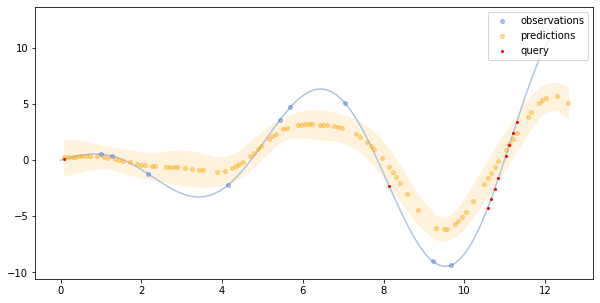

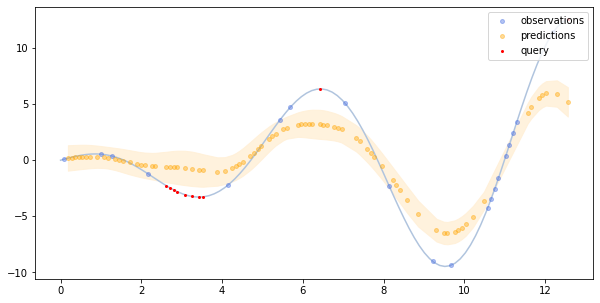

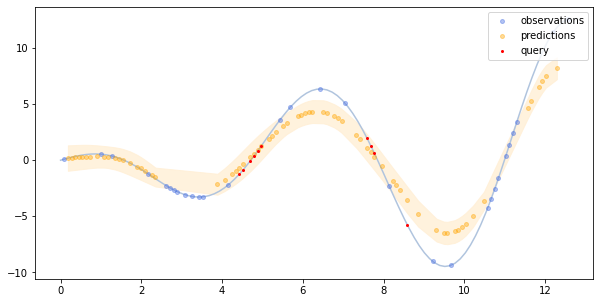

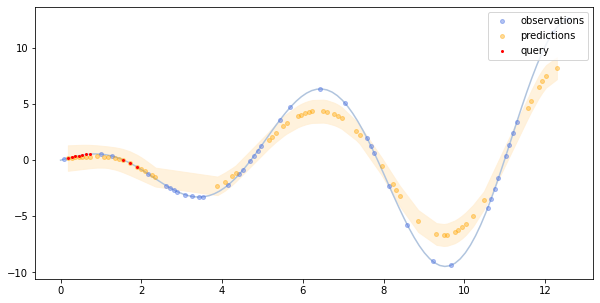

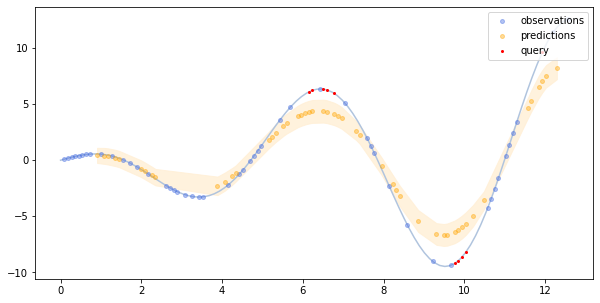

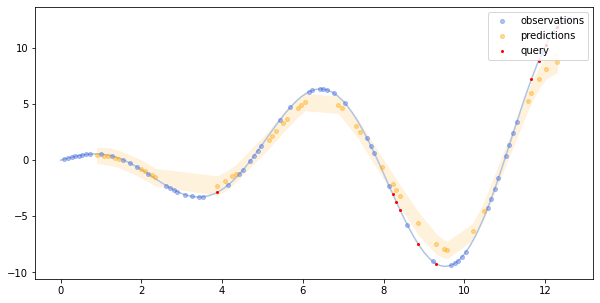

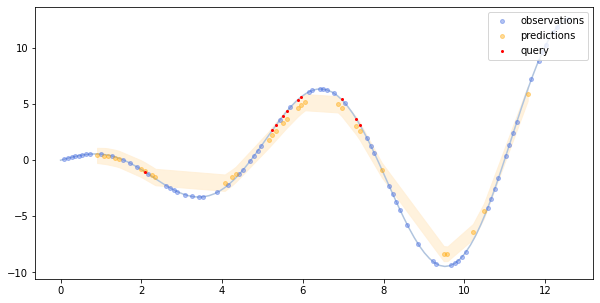

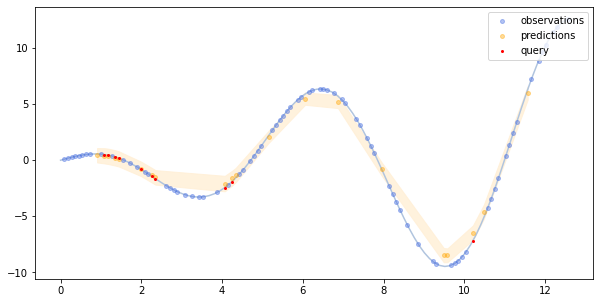

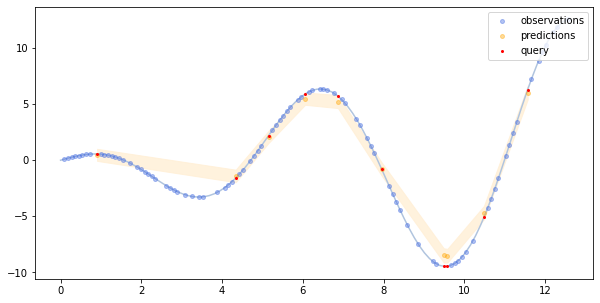

In [22]:
for i in range(len(index_dict['iteration'])):
    plot_gaussian_process(dm, distributions[i], index_dict['iteration'][i])